Оптимизация извлечения металлов из пульпы

Задание:
1. Предобработка данных.
2. Исследовательский анализ.
3. Статистический анализ.
4. Выбор метрик и моделей: не менее 5 моделей с подбором гиперпараметров.
5. Тестирование: проверка модели на тестовых данных, сравнение с дамми-моделью.
6. Выводы.
   
Описание процесса:
Обогатительная фабрика извлекает никель и медь из руды с использованием пенной флотации. Пульпа (руда, вода, реагенты) проходит через несколько флотомашин (ФМ), где из неё получают концентрат (продукт с высоким содержанием металлов). На каждой стадии регулируются параметры пульпы и добавляются реагенты. Концентраты и хвосты обрабатываются отдельно, пока не получат готовый продукт. Основная метрика – извлечение металла в концентрат.

In [253]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.model_selection import train_test_split, RandomizedSearchCV
#from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning

In [254]:
# Игнорирование предупреждений ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [255]:
# Шаг 1: Предобработка данных
# Загрузка набора данных
data = pd.read_csv('df_hack_final.csv')
data['MEAS_DT'] = pd.to_datetime(data['MEAS_DT'])  # Преобразование MEAS_DT в формат datetime

data_test = pd.read_csv('test.csv')
data_test['MEAS_DT'] = pd.to_datetime(data_test['MEAS_DT'])  # Преобразование MEAS_DT в формат datetime

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30336 entries, 0 to 30335
Columns: 130 entries, MEAS_DT to Ni_rec
dtypes: datetime64[ns](1), float64(129)
memory usage: 30.1 MB
None


In [256]:
# Очистка пропущенных и некорректных значений
data = data[(data['Ni_rec'] > 0) & (data['Ni_rec'] < 1)]  # Фильтрация валидных значений Ni_rec
data.dropna(inplace=True)  # Удаление строк с пропущенными значениями

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15838 entries, 2 to 30335
Columns: 130 entries, MEAS_DT to Ni_rec
dtypes: datetime64[ns](1), float64(129)
memory usage: 15.8 MB
None


In [257]:
# Инженерия признаков: извлечение полезных признаков из datetime
data['hour'] = data['MEAS_DT'].dt.hour
data['day_of_week'] = data['MEAS_DT'].dt.dayofweek
data['month'] = data['MEAS_DT'].dt.month

In [258]:
# Выделение признаков, связанных с медью (Cu)
#cu_features = [col for col in data.columns if 'Cu' in col]
#copper_data = data[cu_features]
#data = data.drop(columns=cu_features)

In [259]:
# Сохранение данных, связанных с медью, для будущего анализа
#copper_data.to_csv('copper_data.csv', index=False)

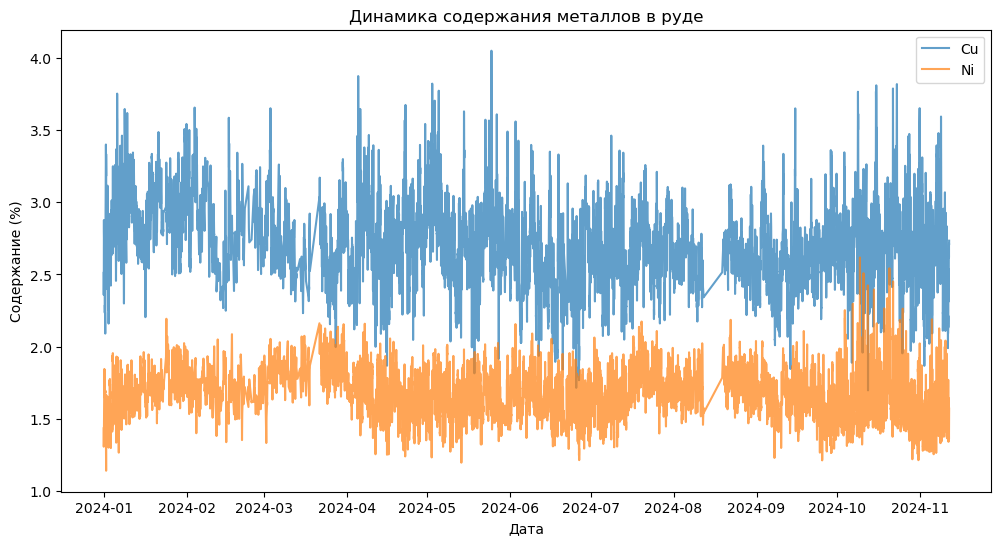

In [260]:
# Шаг 2: Исследовательский анализ данных (EDA)
# Временные ряды меди и никеля
plt.figure(figsize=(12, 6))
plt.plot(data['MEAS_DT'], data['Cu_oreth'], label='Cu', alpha=0.7)
plt.plot(data['MEAS_DT'], data['Ni_oreth'], label='Ni', alpha=0.7)
plt.xlabel('Дата')
plt.ylabel('Содержание (%)')
plt.legend()
plt.title('Динамика содержания металлов в руде')
plt.show()

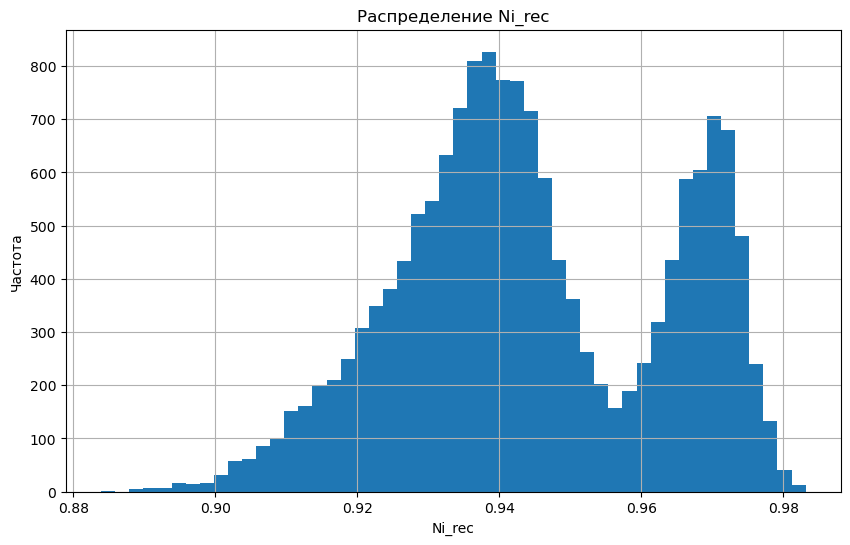

In [261]:
# Визуализация распределений
plt.figure(figsize=(10, 6))
data['Ni_rec'].hist(bins=50)
plt.title('Распределение Ni_rec')
plt.xlabel('Ni_rec')
plt.ylabel('Частота')
plt.show()

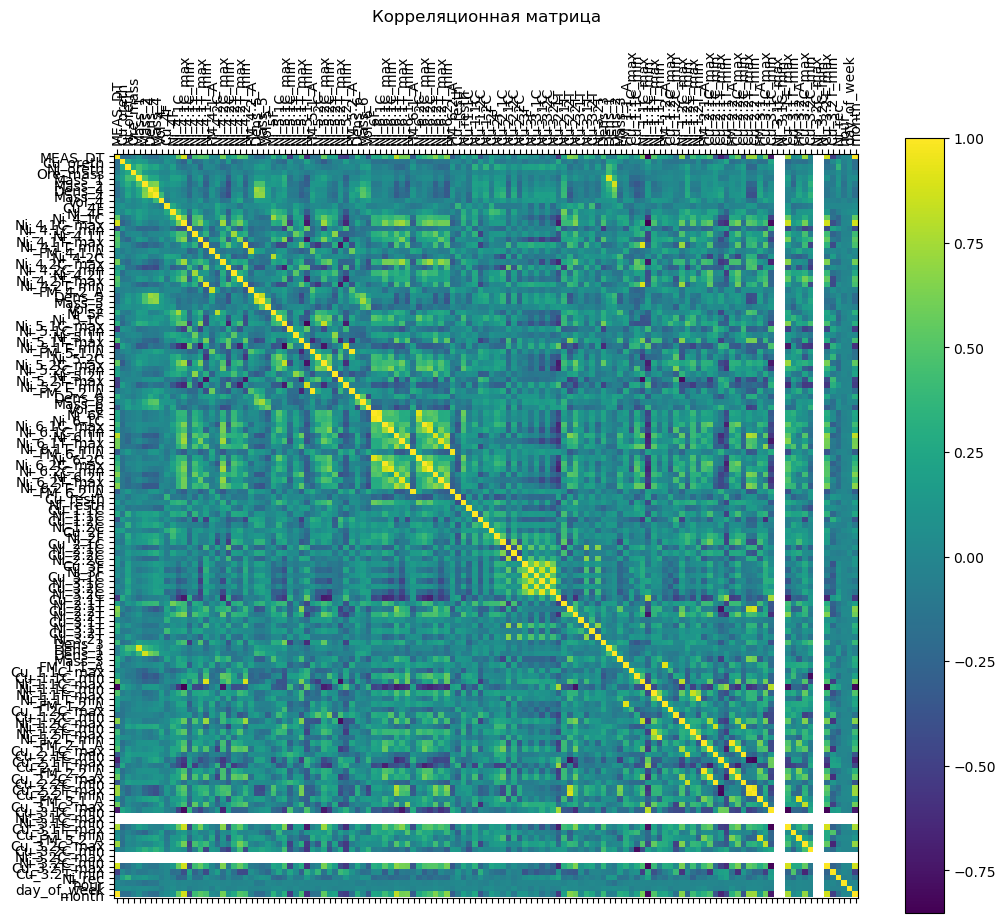

In [262]:
# Корреляционная матрица
correlation = data.corr()
plt.figure(figsize=(12, 10))
plt.matshow(correlation, fignum=1)
plt.xticks(range(correlation.shape[1]), correlation.columns, rotation=90)
plt.yticks(range(correlation.shape[0]), correlation.columns)
plt.colorbar()
plt.title('Корреляционная матрица', pad=20)
plt.show()

In [263]:
# Шаг 3: Статистический анализ
# Вычисление базовых статистик
summary = data.describe()
print("Сводная статистика:")
print(summary)

Сводная статистика:
                             MEAS_DT      Cu_oreth      Ni_oreth  \
count                          15838  15838.000000  15838.000000   
mean   2024-06-24 22:01:01.939638784      2.704827      1.672499   
min              2024-01-01 00:30:00      1.697700      1.141700   
25%              2024-04-22 23:33:45      2.514400      1.557600   
50%              2024-06-26 05:07:30      2.683700      1.669600   
75%              2024-09-08 11:22:30      2.885800      1.780900   
max              2024-11-11 23:45:00      4.048000      2.617300   
std                              NaN      0.287526      0.165681   

           Ore_mass        Mass_1        Mass_2        Dens_4        Mass_4  \
count  15838.000000  15838.000000  15838.000000  15838.000000  15838.000000   
mean    1264.985194   1412.201187    824.848732      1.396745    837.572909   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     1160.500000   1346.716003    781.678497    

In [264]:
from scipy.stats import ttest_ind
import pandas as pd

# Проверка наличия необходимых столбцов в данных
required_columns = {'Ore_mass', 'Cu_oreth'}
if not required_columns.issubset(data.columns):
    raise ValueError(f"Отсутствуют необходимые столбцы: {required_columns - set(data.columns)}")

# Разделение данных на группы
high_mass = data[data['Ore_mass'] > data['Ore_mass'].median()]['Cu_oreth']
low_mass = data[data['Ore_mass'] <= data['Ore_mass'].median()]['Cu_oreth']

# Проведение t-теста
t_stat, p_value = ttest_ind(high_mass, low_mass, equal_var=False)  # Используем Welch's t-test

# Вывод результатов
print(f"T-статистика: {t_stat:.4f}, p-значение: {p_value:.4e}")

# Интерпретация результата
alpha = 0.05
if p_value < alpha:
    print("Различия между группами статистически значимы.")
else:
    print("Нет статистически значимых различий между группами.")

T-статистика: 16.2957, p-значение: 3.2241e-59
Различия между группами статистически значимы.


In [265]:
# Шаг 4: Выбор моделей и настройка гиперпараметров
# Определение признаков и целевой переменной
features = data.drop(columns=['Ni_rec', 'MEAS_DT'])
target = data['Ni_rec']

In [266]:
# Подготовка данных
X = data.drop(columns=['MEAS_DT', 'Cu_oreth'], errors='ignore')
y = data['Cu_oreth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [267]:
# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [268]:
# Уменьшение объема данных для гиперпараметрического поиска
sample_frac = 0.1
X_train_sample = X_train.sample(frac=sample_frac, random_state=42)  # Выбираем подвыборку из DataFrame
y_train_sample = y_train.loc[X_train_sample.index]  # Сопоставляем индексы для y_train

# Масштабируем только выбранные данные
X_train_small = scaler.transform(X_train_sample)
y_train_small = y_train_sample.values  # Преобразуем в массив для совместимости

In [269]:
# Модели и гиперпараметры
model_params = {
    "RandomForest": (RandomForestRegressor(), {"n_estimators": [50, 100], "max_depth": [10, 20]}),
    "GradientBoosting": (GradientBoostingRegressor(), {"learning_rate": [0.1], "n_estimators": [50]}),
    "LinearRegression": (LinearRegression(), {}),
    "SVR": (SVR(max_iter=20000), {"C": [1, 10], "kernel": ["linear"]}),
    "KNeighbors": (KNeighborsRegressor(), {"n_neighbors": [3, 5]})
}

In [270]:
# Функция для оценки метрик
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "R2": r2_score(y_test, y_pred)
    }

In [271]:
# Функция для оценки метрик
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "R2": r2_score(y_test, y_pred)
    }

In [272]:
# Обучение моделей
results = []

for name, (model, params) in model_params.items():
    print(f"Обучение модели: {name}")
    
    try:
        if params:  # Гиперпараметрический поиск
            search = RandomizedSearchCV(
                model, params, n_iter=1, scoring="neg_mean_absolute_error", cv=2, n_jobs=-1, random_state=42
            )
            search.fit(X_train_small, y_train_small)
            best_model = search.best_estimator_
        else:  # Если гиперпараметры не указаны
            best_model = model.fit(X_train_small, y_train_small)

        # Оценка метрик
        metrics = evaluate_model(best_model, X_test_scaled, y_test)
        results.append({"Model": name, **metrics})
        print(f"{name} - MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}")

    except Exception as e:
        print(f"Ошибка в модели {name}: {e}")
        results.append({"Model": name, "MAE": None, "RMSE": None, "R2": None})

Обучение модели: RandomForest
RandomForest - MAE: 0.1609, RMSE: 0.2111, R2: 0.4347
Обучение модели: GradientBoosting
GradientBoosting - MAE: 0.1694, RMSE: 0.2191, R2: 0.3914
Обучение модели: LinearRegression
LinearRegression - MAE: 0.1735, RMSE: 0.2231, R2: 0.3690
Обучение модели: SVR
SVR - MAE: 0.3534, RMSE: 0.4364, R2: -1.4149
Обучение модели: KNeighbors
KNeighbors - MAE: 0.1733, RMSE: 0.2285, R2: 0.3379


In [273]:
# Вывод результатов в виде таблицы
results_df = pd.DataFrame(results)
print("\nПроизводительность моделей:")
print(results_df)


Производительность моделей:
              Model       MAE      RMSE        R2
0      RandomForest  0.160873  0.211113  0.434740
1  GradientBoosting  0.169352  0.219054  0.391418
2  LinearRegression  0.173467  0.223057  0.368973
3               SVR  0.353417  0.436352 -1.414856
4        KNeighbors  0.173280  0.228484  0.337894


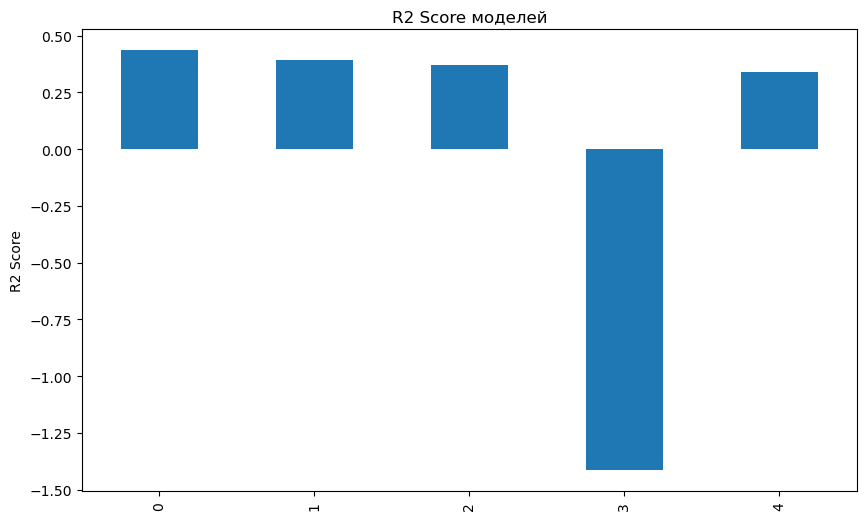

In [274]:
# Шаг 6: Выводы
# Визуализация производительности моделей
results_df['R2'].plot(kind='bar', figsize=(10, 6), title='R2 Score моделей')
plt.ylabel('R2 Score')
plt.show()


In [275]:
# Создание и обучение дамми-модели
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)

# Прогноз на тестовой выборке
dummy_predictions = dummy_model.predict(X_test)

# Вычисление метрик
metrics = {
    "MAE": mean_absolute_error(y_test, dummy_predictions),
    "RMSE": mean_squared_error(y_test, dummy_predictions, squared=False),
    "R2": r2_score(y_test, dummy_predictions),
}

# Вывод результатов
print("Результаты Dummy-модели:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Результаты Dummy-модели:
MAE: 0.2198
RMSE: 0.2808
R2: -0.0001


Проведён анализ данных временных рядов, корреляций и статистических тестов, а также построено несколько моделей для прогнозирования содержания меди:
Анализ временных рядов выявил колебания в концентрациях меди и никеля, что связано с изменениями сырья и процесса. 
1. Необходима оптимизация параметров для стабильности.
2. Корреляционный анализ выявил ключевые взаимосвязи между признаками, влияющими на содержание металлов.
3. Статистический анализ подтвердил значимые различия в содержании металлов при изменении массы пульпы.

Моделирование:
Лучшей моделью по предоставленным метрикам является RandomForest, так как она имеет наилучшие показатели по всем ключевым метрикам:
Наименьшее MAE: 0.160873 (ошибка прогноза минимальна).
Наименьшее RMSE: 0.211113 (ошибка прогноза в квадратичном смысле минимальна).
Наибольший R²: 0.434740 (наилучшая объяснённая дисперсия).
Остальные модели уступают по всем показателям. Особенно SVR, которая имеет отрицательный R², что говорит о её неспособности адекватно объяснять вариации данных.

Сравнение с дамми-моделью: 
Dummy-модель показала значительно худшие результаты по всем метрикам, особенно:
1. Высокие значения MAE и RMSE указывают на большую среднюю и квадратичную ошибки.
2. Отрицательное значение R² подтверждает, что модель хуже предсказывает, чем простое среднее.
    RandomForest остаётся лучшей моделью:
    - MAE: 0.160873, что лучше, чем у Dummy (на 26,8% меньше).
    - RMSE: 0.211113, что значительно меньше, чем у Dummy (на 24,8% меньше).
    - R²: 0.434740, что указывает на успешное объяснение 43,5% дисперсии целевой переменной.
3. Все обученные модели (кроме SVR) превзошли Dummy-модель, что подтверждает их способность находить закономерности в данных.

Рекомендация:
Использовать RandomForest как основную модель для прогнозирования, поскольку она показывает лучшую производительность, особенно по сравнению с Dummy-моделью, демонстрируя значимую предсказательную силу.

